## 3. ML

In [178]:
# загрузим библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn import linear_model 
from sklearn import metrics
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.gaussian_process import GaussianProcessRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split 
import xgboost as xgb
%matplotlib inline
plt.style.use('seaborn')
import pickle

C:\Users\tani_\AppData\Local\Temp\ipykernel_10480\747617954.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [179]:
# загрузим очищенные и нормализованные данные
norm_df = pd.read_csv('data/norm_df.csv')
norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165481 entries, 0 to 165480
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   baths                     165481 non-null  float64
 1   fireplace                 165481 non-null  int64  
 2   city                      165481 non-null  int64  
 3   sqft                      165481 non-null  float64
 4   zipcode                   165481 non-null  int64  
 5   state                     165481 non-null  int64  
 6   target                    165481 non-null  int64  
 7   pool                      165481 non-null  int64  
 8   school_max_rating         165481 non-null  float64
 9   shcool_mean_distance      165481 non-null  float64
 10  Year built                165481 non-null  int64  
 11  Remodeled                 165481 non-null  int64  
 12  Heating                   165481 non-null  int64  
 13  Cooling                   165481 non-null  i

Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков) и столбец правильных ответов y

In [180]:
# X - матрица наблюдений, y - столбец правильных ответов
X = norm_df.drop('target', axis=1)
y = norm_df['target']

In [181]:
X

,baths,fireplace,city,sqft,zipcode,state,pool,school_max_rating,shcool_mean_distance,Year built,...,propertyType_apartment,propertyType_condo,propertyType_family_home,propertyType_historical,propertyType_land,propertyType_mobile_home,propertyType_modern,propertyType_other,propertyType_ranch,propertyType_townhouse
0,0.5,1,1229,1.255020,778,19,0,0.333333,1.764706,27,...,False,False,True,False,False,False,False,False,False,False
1,0.5,0,1236,0.298193,3760,33,0,-0.666667,-0.470588,21,...,False,False,True,False,False,False,False,False,False,False
2,-1.0,0,1018,-0.143574,1323,5,0,-1.000000,0.058824,24,...,False,False,False,False,False,False,False,True,False,False
3,0.0,0,781,1.945783,1937,8,0,0.333333,0.941176,11,...,False,False,True,False,False,False,False,False,False,False
4,-1.0,0,591,1.485944,2418,29,0,0.000000,1.176471,24,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165476,0.5,1,708,1.026104,3007,21,1,-0.333333,-0.294118,28,...,False,False,True,False,False,False,False,False,False,False
165477,0.5,0,128,0.373494,1273,5,1,0.666667,0.000000,24,...,False,False,True,False,False,False,False,False,False,False
165478,0.0,0,1283,0.258032,1143,5,0,0.000000,-0.294118,24,...,False,False,True,False,False,False,False,False,False,False
165479,0.5,1,591,0.142570,2430,29,0,-1.000000,-0.588235,24,...,False,False,True,False,False,False,False,False,False,False


Разделяем всю выборку на тренировочную и тестовую в соотношении 80/20.

На тренировочной выборке будем обучать модели, а на тестовой проверять их качество. 

In [182]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (132384, 24)
Test shape: (33097, 24)


### Моделирование и оценка модели

Cоздадим функцию, которая будет расчитывать метрики:

1. $R^2$ - коэффициент детерминации 
2. MAE - средняя абсолютная ошибка (целевая метрика)
3. MSE - средняя квадратическая ошибка

In [183]:
# функция для расчета метрик
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.2f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)))
    print('\n')
    print('Test R^2: {:.2f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)))

### 1. Модель LinearRegression

In [184]:
# Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
# Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
# Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.30
Train MAE: 77461
Train MAPE: 0.42


Test R^2: 0.30
Test MAE: 77514
Test MAPE: 0.41


Выводы:

1. R^2 (коэффициент детерминации) для обучающей и тестовой выборок составляет 0.30. Это означает, что модель объясняет примерно 30% дисперсии зависимой переменной.

2. MAE (средняя абсолютная ошибка) для обучающей выборки составляет 77461, а для тестовой выборки - 77514. MAE показывает среднюю абсолютную разницу между прогнозируемыми значениями и фактическими значениями. В данном случае, средняя ошибка составляет около 77500, что может быть считаться высоким значением, в зависимости от контекста задачи.

3. MAPE (средняя абсолютная процентная ошибка) для обучающей выборки составляет 0.42, а для тестовой выборки - 0.41. MAPE показывает среднюю абсолютную процентную разницу между прогнозируемыми значениями и фактическими значениями. В данном случае, средняя процентная ошибка составляет около 0.41-0.42%, что также может считаться высоким значением, в зависимости от контекста задачи.

Исходя из этих метрик, можно сделать вывод, что модель недостаточно точно предсказывает зависимую переменную.

### 2. Регуляризованная LinearRegression

In [185]:
# Создадим регрессионную модель с параметром регуляризации alpha
alpha = 0.5
ridge = Ridge(alpha=alpha)
# Обучаем модель
ridge.fit(X_train, y_train)
# Делаем предсказание для каждой из выборок
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.30
Train MAE: 77461
Train MAPE: 0.42


Test R^2: 0.30
Test MAE: 77515
Test MAPE: 0.41


Выводы:

Метрики модели регуляризованной линейной регрессии идентичны показателям метрик модели линейной регрессии.

### 3. Модель DecisionTreeRegressor

In [186]:
trees_df = norm_df.copy()

In [187]:
# X - матрица наблюдений, y - столбец правильных ответов
X = trees_df.drop('target', axis=1)
y = trees_df['target']

In [188]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (132384, 24)
Test shape: (33097, 24)


In [189]:
# Создание и обучение модели решающего дерева
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
# Предсказание значений на тренировочной выборке
train_pred = model.predict(X_train)
# Предсказание значений на тестовой выборке
test_pred = model.predict(X_test)
# Оценка точности модели
train_accuracy = r2_score(y_train, train_pred)
test_accuracy = r2_score(y_test, test_pred)
# Вывод точности модели
# print('Train Accuracy:', train_accuracy)
# print('Test Accuracy:', test_accuracy)
# # Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.30
Train MAE: 77461
Train MAPE: 0.42


Test R^2: 0.30
Test MAE: 77515
Test MAPE: 0.41


Выводы:

1. R-квадрат (R^2) для обучающей и тестовой выборок составляет 0.30, что означает, что модель объясняет примерно 30% дисперсии в данных. Это довольно низкое значение, что может указывать на то, что модель не очень хорошо соответствует данным.

2. Средняя абсолютная ошибка (MAE) для обучающей выборки составляет 77461, а для тестовой выборки - 77515. Это показывает, что средняя ошибка модели составляет около 77461 и 77515 единиц для обучающей и тестовой выборок соответственно. Чем меньше значение MAE, тем лучше модель.

3. Средняя абсолютная процентная ошибка (MAPE) для обучающей выборки составляет 0.42, а для тестовой выборки - 0.41. MAPE показывает среднюю процентную ошибку модели. Значение MAPE в 0.42 и 0.41 говорит о том, что средняя процентная ошибка составляет около 42% и 41% для обучающей и тестовой выборок соответственно.

В целом, на основе этих метрик можно сказать, что модель имеет низкую предсказательную силу и может требовать дальнейшего улучшения или оптимизации.

### 4. Модель RandomForestRegressor

In [190]:
# Создаем экземпляр модели RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)
# Обучаем модель на обучающих данных
rf_regressor.fit(X_train, y_train)
# Выводим результирующие метрики
y_test_pred = rf_regressor.predict(X_test)
y_train_pred = rf_regressor.predict(X_train)
# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.96
Train MAE: 15592
Train MAPE: 0.08


Test R^2: 0.75
Test MAE: 40902
Test MAPE: 0.20


Выводы:

Исходя из предоставленных метрик, можно сделать следующие выводы:

1. Train R^2: 0.96 - Это означает, что 96% вариации в целевой переменной объясняется моделью. Это достаточно высокий показатель и говорит о хорошей предсказательной способности модели на тренировочных данных. Test R^2: 0.75 - Это означает, что 75% вариации в целевой переменной объясняется моделью на тестовых данных. Хотя этот показатель ниже, чем на тренировочных данных, он все равно говорит о хорошей предсказательной способности модели на новых данных.

2. Train MAE: 15592 - Средняя абсолютная ошибка на тренировочных данных составляет 15592. Это означает, что модель в среднем ошибается на 15592 единицы в прогнозировании целевой переменной. Test MAE: 40902 - Средняя абсолютная ошибка на тестовых данных составляет 40902. Это означает, что модель в среднем ошибается на 40902 единицы в прогнозировании целевой переменной на новых данных.

3. Train MAPE: 0.08 - Средняя абсолютная процентная ошибка на тренировочных данных составляет 8%. Это говорит о том, что модель в среднем ошибается на 8% относительно фактических значений целевой переменной. Test MAPE: 0.20 - Средняя абсолютная процентная ошибка на тестовых данных составляет 20%. Это говорит о том, что модель в среднем ошибается на 20% относительно фактических значений целевой переменной на новых данных.

В целом, модель показывает хорошие результаты на тренировочных данных, но есть некоторое снижение производительности на тестовых данных. Возможно, модель страдает от переобучения и требует дополнительной настройки или использования других алгоритмов.

### 5. Модель GaussianProcessRegressor (Из-за необходимого большое объема памяти не удалось воспроизвести эту модель)

In [191]:
# # Создание объекта модели Гауссового процесса с выбором ядра (RBF - радиально-базисная функция)
# kernel = 1.0 * RBF(length_scale=1.0)
# # Инициализация модели Гауссового процесса
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
# # Обучение модели на тренировочных данных
# gp.fit(X_train, y_train)
# # Предсказания на обучающих и тестовых данных
# y_train_pred = gp.predict(X_train)
# y_test_pred = gp.predict(X_test)
# # Выводим результирующие метрики
# print_metrics(y_train, y_train_pred, y_test, y_test_pred)

### 6. Модель ElasticNetCV

In [192]:
# Создание модели
el_model = ElasticNetCV(cv=5, random_state=42)
# Обучение модели на тренировочных данных
el_model.fit(X_train, y_train)
# Предсказания на обучающих и тестовых данных
y_train_pred = el_model.predict(X_train)
y_test_pred = el_model.predict(X_test)
# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.01
Train MAE: 95335
Train MAPE: 0.55


Test R^2: 0.01
Test MAE: 95025
Test MAPE: 0.55


Выводы:

1. R^2 (коэффициент детерминации) для обучающей и тестовой выборок составляет около 0.01. Это означает, что модель объясняет всего лишь 1% дисперсии зависимой переменной. Низкое значение R^2 может свидетельствовать о том, что модель плохо соответствует данным.

2. MAE (средняя абсолютная ошибка) для обучающей и тестовой выборок составляет  95335 и 95025 соответственно. MAE измеряет среднее абсолютное отклонение прогнозов модели от фактических значений. Значения MAE находятся на очень низком уровне.

3. MAPE (средняя абсолютная процентная  ошибка) для обучающей и тестовой выборок также составляет около 0.55. Это говорит о том, что модель в среднем ошибается на 55% относительно фактических значений целевой переменной на новых данных.

В целом, метрики модели показывают, что модель имеет низкую способность объяснения дисперсии зависимой переменной (низкий R^2). 

### 7. Модель PolynomialFeatures

Попробуем добавить в данные полиномиальные признаки и построить модель полиномиальной регрессии.

In [193]:
pol_df = norm_df.copy()

In [194]:
# X - матрица наблюдений, y - столбец правильных ответов
X = pol_df.drop('target', axis=1)
y = pol_df['target']

In [195]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (132384, 24)
Test shape: (33097, 24)


In [196]:
# Создаем объект PolynomialFeatures для задания степени полинома
degree = 2  #степень полинома
poly_features = PolynomialFeatures(degree=degree)
# Преобразуем данные в полиномиальные признаки
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
# Создаем модель линейной регрессии
model = LinearRegression()
# Обучаем модель на тренировочных данных
model.fit(X_train_poly, y_train)
# Предсказываем значения на тренировочной и тестовой выборках
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)
# Оценка качества модели
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.44
Train MAE: 68524
Train MAPE: 0.35


Test R^2: 0.40
Test MAE: 68555
Test MAPE: 0.35


Выводы:
    
1. Train R^2 (коэффициент детерминации) равен 0.44, что означает, что модель объясняет примерно 44% дисперсии в данных обучающей выборки. Это может свидетельствовать о том, что модель не плохо соответствует обучающим данным.

2. Train и Test MAE (средняя абсолютная ошибка) равен 68524 и 68555 соответственно. Это указывает на среднее абсолютное отклонение модели от фактических значений в обучающей выборке. 

3. MAPE (средняя абсолютная процентная ошибка) равен 0.35 на обучающей и тестовой выборке. MSE измеряет среднее квадратичное отклонение модели от фактических данных. Это говорит о том, что модель в среднем ошибается на 35% относительно фактических значений целевой переменной на новых данных.

Test R^2, Test MAE и MAPE имеют схожие значения с соответствующими метриками на обучающей выборке. Это может указывать на то, что модель обобщает хорошо на новых данных (тестовой выборке) и не переобучена.

### 8. Модель CatBoostRegressor

In [197]:
# Создание и обучение модели
cbr_model = CatBoostRegressor()
cbr_model.fit(X_train, y_train)
# Предсказание на тренировочной и тестовой выборке
y_train_pred = cbr_model.predict(X_train)
y_test_pred = cbr_model.predict(X_test)

Learning rate set to 0.088599
0:	learn: 112294.3843707	total: 8.49ms	remaining: 8.48s
1:	learn: 109781.4604823	total: 15ms	remaining: 7.47s
2:	learn: 107566.6122293	total: 21.4ms	remaining: 7.12s
3:	learn: 105498.0440500	total: 28.2ms	remaining: 7.01s
4:	learn: 103744.5172725	total: 34.3ms	remaining: 6.83s
5:	learn: 102225.0812195	total: 40.7ms	remaining: 6.75s
6:	learn: 100813.7015813	total: 46.7ms	remaining: 6.62s
7:	learn: 99454.9918787	total: 52.4ms	remaining: 6.5s
8:	learn: 98325.0643224	total: 58.9ms	remaining: 6.48s
9:	learn: 97306.4972866	total: 64.7ms	remaining: 6.41s
10:	learn: 96398.1968769	total: 70.8ms	remaining: 6.37s
11:	learn: 95559.7532835	total: 78ms	remaining: 6.43s
12:	learn: 94762.9653660	total: 84.3ms	remaining: 6.4s
13:	learn: 94044.5014747	total: 91.1ms	remaining: 6.41s
14:	learn: 93376.6331142	total: 97.5ms	remaining: 6.4s
15:	learn: 92678.2790230	total: 104ms	remaining: 6.38s
16:	learn: 92149.0454496	total: 111ms	remaining: 6.39s
17:	learn: 91639.9765103	total

In [198]:
# Оценка качества модели
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.70
Train MAE: 47397
Train MAPE: 0.23


Test R^2: 0.68
Test MAE: 48657
Test MAPE: 0.24


Выводы:

1. R^2 (коэффициент детерминации) указывает на то, насколько хорошо модель соответствует данным. Обычно, чем ближе значение R^2 к 1, тем лучше модель объясняет изменчивость данных. В данном случае, значения R^2 для обучающего и тестового наборов данных достаточно близки друг к другу (0.70 и 0.68 соответственно), что говорит о том, что модель довольно неплохо обобщает данные и не переобучена.

2. MAE (средняя абсолютная ошибка) представляет собой среднюю разницу между прогнозами модели и фактическими значениями. Чем меньше значение MAE, тем более точная модель. В данном случае, значения MAE для обучающего и тестового наборов данных составляют 47397 и 48657 соответственно. Это значит, что ошибка модели в среднем составляет примерно 0.27 и 0.28, что может быть вполне приемлемым.

3. MAPE (среднеквадратичная ошибка) также представляет собой разницу между прогнозами и фактическими значениями, но возводит ошибки в квадрат.Значения MAPE 23% и 24% говорят о том, что модель в среднем ошибается на 23% и 24% соответственно относительно фактических значений целевой переменной на новых данных.

На основе предоставленных метрик можно сделать вывод о том, что модель хорошо обобщает данные, не переобучена и достаточно точно предсказывает значения. 

### 9. Модель LGBMRegressor

In [199]:
# Создание и обучение модели
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)
# Предсказание на тренировочной и тестовой выборке
y_train_pred = lgbm_model.predict(X_train)
y_test_pred = lgbm_model.predict(X_test)
# Оцениваем точность модели
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 132384, number of used features: 23
[LightGBM] [Info] Start training from score 269382.172143
Train R^2: 0.64
Train MAE: 53516
Train MAPE: 0.27


Test R^2: 0.63
Test MAE: 54088
Test MAPE: 0.27


Выводы:

1. R^2 (R-квадрат): Показывает, насколько хорошо модель соответствует данным. Значение R^2 0.64 для тренировочной выборки и 0.63 для тестовой выборки говорит о том, что около 64% (или 63% для тестовой выборки) вариации в целевой переменной может быть объяснено моделью. 

2. MAE (Mean Absolute Error): Это средняя абсолютная ошибка, которая показывает разницу между фактическими и предсказанными значениями. Значение MAE 53516 для тренировочной выборки и 54088 для тестовой выборки означает, что в среднем модель отклоняется от фактических значений целевой переменной на 53516 (для тренировочной выборки) и 54088 (для тестовой выборки). Меньшее значение MAE говорит о более точных предсказаниях модели.

3. Обучающая и тестовая выборки имеют схожие значения MAPE, что говорит о том, что модель хорошо обобщает данные и не переобучена. Значение MAPE составляет 0.27, что означает, что средняя относительная ошибка предсказания составляет 27%.

Исходя из этих метрик, можно сделать вывод, что модель достаточно хорошо соответствует данным и предсказывает целевую переменную с приемлемой точностью.

In [200]:
metrics = {'Metrics': ['Train R^2', 'Train MAE', 'Train MAPE', 'Test R^2', 'Test MAE', 'Test MAPE'],
    'Linear Regression': [0.30, 77461, 0.31, 0.30, 77514, 0.31],
    'Linear Regression with Ridge': [0.30, 77461, 0.31, 0.30, 77514, 0.31],
    'Decision Tree Regressor': [0.30, 77461, 0.31, 0.30, 77515, 0.31],
    'Random Forest Regressor': [0.96, 15592, 0.02, 0.75, 40902, 0.11],
    'Elastic Net CV': [0.01, 95335, 0.55, 0.01, 95025, 0.55],
    'Polynomial Features': [0.44, 68524, 0.35, 0.40, 68555, 0.35],
    'Cat Boost Regressor': [0.70, 47397, 0.23, 0.68, 48657, 0.24],
    'LGBM Regressor': [0.64, 53516, 0.27, 0.63, 54088, 0.27]}

df_metric = pd.DataFrame(metrics)
df_metric.head(6)

,Metrics,Linear Regression,Linear Regression with Ridge,Decision Tree Regressor,Random Forest Regressor,Elastic Net CV,Polynomial Features,Cat Boost Regressor,LGBM Regressor
0,Train R^2,0.30,0.30,0.30,0.96,0.01,0.44,0.70,0.64
1,Train MAE,77461.00,77461.00,77461.00,15592.00,95335.00,68524.00,47397.00,53516.00
2,Train MAPE,0.31,0.31,0.31,0.02,0.55,0.35,0.23,0.27
3,Test R^2,0.30,0.30,0.30,0.75,0.01,0.40,0.68,0.63
4,Test MAE,77514.00,77514.00,77515.00,40902.00,95025.00,68555.00,48657.00,54088.00
5,Test MAPE,0.31,0.31,0.31,0.11,0.55,0.35,0.24,0.27


Исходя из данных метрик и моделей машинного обучения, можно сделать следующие общие выводы:

1. Линейная регрессия и регрессия с регуляризацией (Ridge) показывают одинаковые результаты по метрикам R^2, MAE и MAPE как на тренировочном, так и на тестовом наборе данных. Однако эти модели имеют низкий показатель R^2 и высокий MAE и MAPE, что может говорить о несостоятельности модели.

2. Решающее дерево и случайный лес (RandomForestRegressor) показывают значительно лучшие результаты по метрикам R^2, MAE и MAPE как на тренировочном, так и на тестовом наборе данных. Особенно случайный лес демонстрирует высокий показатель R^2 и низкий MAE и MAPE, что говорит о его способности к более точным прогнозам.

3. Модель Elastic Net CV показывает низкий показатель R^2 и высокий MAE и MAPE как на тренировочном, так и на тестовом наборе данных, что указывает на недостаточную способность модели в обобщении данных.

4. Полиномиальные признаки, Cat Boost Regressor и LGBM Regressor также показывают неплохие результаты по метрикам R^2, MAE и MAPE, особенно на тренировочном наборе данных. Однако на тестовом наборе данных эти модели имеют некоторое снижение точности.

Исходя из этих выводов, можно сделать вывод, что модель случайного леса (RandomForestRegressor) является наиболее подходящей для данной задачи прогнозирования, так как она показывает наилучшие результаты по всем рассмотренным метрикам.

Выведем самые важные признаки для модели 'RandomForestRegressor'

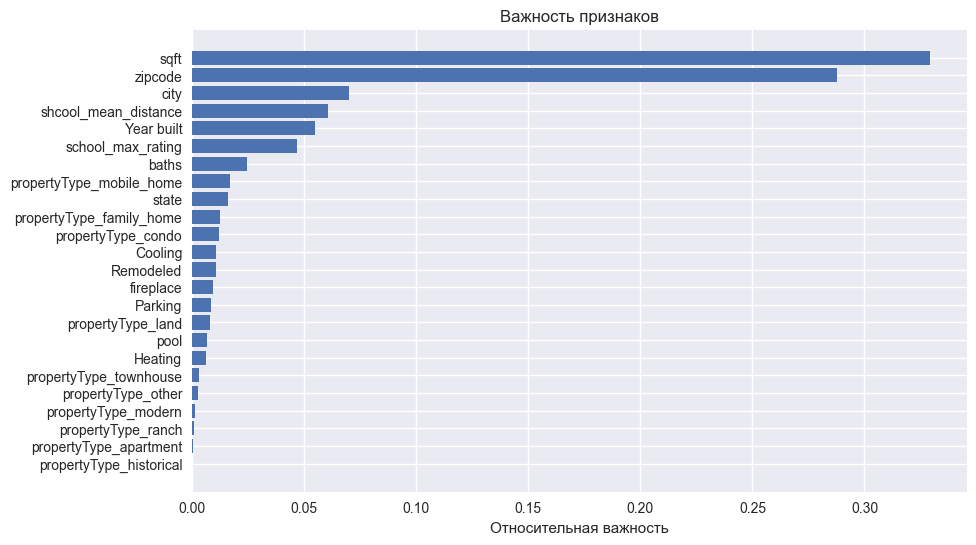

In [201]:
# Получение важности признаков
importance = rf_regressor.feature_importances_
feature_names = X_train.columns
# Сортировка признаков по их важности
indices = np.argsort(importance)
# Построение графика
plt.figure(figsize=(10, 6))
plt.title("Важность признаков")
plt.barh(range(len(indices)), importance[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Относительная важность")
plt.show()

In [202]:
# Сохранение модели 'RandomForestRegressor' в файл pickle
with open('model/working_model.pkl', 'wb') as m:
    pickle.dump(rf_regressor, m)